In [1]:
from google.colab import drive
drive.mount('/content/drive')

!ls "/content/drive/My Drive/CEA - CosmoStat/Week 2"
%cd /content/drive/My Drive/CEA - CosmoStat/Week 2

!apt-get -qq update; apt-get install -y python-dev libfftw3-dev libeigen3-dev ffmpeg pybind11-dev
!pip install plotly tfa-nightly tqdm numpy matplotlib
!pip install rmjarvis.eigency>=1.77.1
!pip install scikit-image
!pip install tensorflow-addons

Mounted at /content/drive
'=1.77.1'				  filters_simple_drop_0.2.png
 constrained_learnlet_vertical.ipynb	  filters_simple_drop_0.3.png
 constraint_sv_epochs.txt		  filters_simple_drop_0.5.png
'Contrainte SVD vs Dropout.gslides'	  filters_simple_drop_0.7.png
 denoising_learned_filter_ver_hor.ipynb   filters_simple_drop_0.9.png
 denoising_original.png			  filters_simple_original.png
 denoising_thr_0.3.png			  filters_simple_res_drop_0.3n0.5.png
 denoising_thr_0.5.png			  filters_simple_res_drop_0.9.png
 denoising_thr_0.7.png			  filters_simple_res_thr_0.9.png
 eigen_denoising.png			  filters_simple_thr_0.3.png
 eigen_filters.png			  filters_simple_thr_0.5.png
 eigen_res.png				  filters_simple_thr_0.7.png
 filters_cst_thr_0.3.png		  filters_simple_thr_0.8.png
 filters_cst_thr_0.5.png		  filters_simple_thr_0.9.png
 filters_cst_thr_0.7.png		  filters_thr_0.3.png
 filters_simple_cst_drop_0.2.png	  filters_thr_0.5.png
 filters_simple_cst_drop_0.3.png	  filters_thr_0.7.png
 filters_simple_cs

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Subtract, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow_addons as tfa
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle


from learnlets.learnlet_model import Learnlet
from learnlets.keras_utils.normalisation import NormalisationAdjustment
from learnlets.keras_utils.image_tboard_cback import TensorBoardImage
from learnlets.keras_utils.thresholding import DynamicSoftThresholding, DynamicHardThresholding

In [3]:
plt.rcParams['figure.figsize'] = (9, 5)

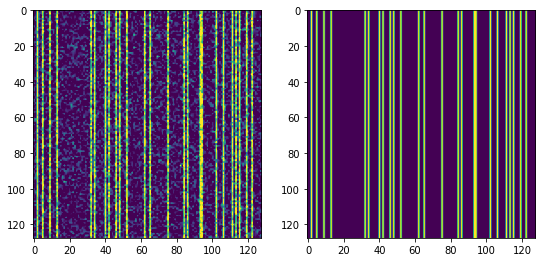

In [4]:
np.random.seed(seed=10)
noise_std_train = (0, 55)
noise_std_val = 30
batch_size = 8
im_size = 128
prop_bands = 0.2
n_images = 15000
proportion_train_val = 0.8

new_vignets_noiseless = np.zeros((n_images,im_size,im_size))
new_vignets_with_noise = np.zeros((n_images,im_size,im_size))
std = np.zeros((n_images,1))

for it in range(n_images):
  im = np.zeros((im_size, im_size), dtype=np.float64)
  band_locations = np.random.randint(0, im_size, int(prop_bands * im_size))
  im[:, band_locations] = 1.0
  new_vignets_noiseless[it,:,:] = im

  if it > proportion_train_val*n_images:
      noise_std_range = (noise_std_val, noise_std_val)
  else: 
      noise_std_range = noise_std_train

  noise_std = tf.random.uniform(
      (1,),
      minval=noise_std_range[0],
      maxval=noise_std_range[1],
  )
  
  noise = tf.random.normal(shape=tf.shape(im), mean=0.0, stddev=noise_std/255, dtype=tf.float32)
  std[it] = noise_std/255
  new_vignets_with_noise[it,:,:] = im+noise

fig, axs = plt.subplots(1, 2)

axs[0].imshow(np.squeeze(new_vignets_with_noise[10,:,:]), vmin=0, vmax=1)
axs[1].imshow(np.squeeze(new_vignets_noiseless[10,:,:]), vmin=0, vmax=1)

train_dic = {'VIGNET_NOISELESS':new_vignets_noiseless,'VIGNETS_WITH_NOISE':new_vignets_with_noise,  
             'TRUE_NOISE': std}

In [5]:
def keras_psnr(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, 1)

def keras_ssim(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, 1)

def center_keras_psnr(y_true, y_pred):
    return tf.image.psnr(_tf_crop(y_true, crop=128), _tf_crop(y_pred, crop=128), 1)

In [6]:
n_train = int(n_images*proportion_train_val)

im_train, im_val, target_train, target_val = train_test_split(train_dic['VIGNETS_WITH_NOISE'], train_dic['VIGNET_NOISELESS'], 
                                                              shuffle=False, stratify=None, test_size=1-proportion_train_val, random_state=10)
sigma = train_dic['TRUE_NOISE']
im_train, target_train, sigma[0:n_train] = shuffle(im_train, target_train, sigma[0:n_train])

im_train = (tf.reshape(tf.convert_to_tensor(im_train), [n_train, im_size, im_size, 1]))
target_train = tf.reshape(tf.convert_to_tensor(target_train), [n_train, im_size, im_size, 1])
im_val = (tf.reshape(tf.convert_to_tensor(im_val), [n_images-n_train, im_size, im_size, 1]))
target_val = tf.reshape(tf.convert_to_tensor(target_val), [n_images-n_train, im_size, im_size, 1])
sigma_train = tf.reshape(tf.convert_to_tensor(sigma[0:n_train]), [n_train, 1])
sigma_val = tf.reshape(tf.convert_to_tensor(sigma[n_train:n_images]), [n_images-n_train, 1])

run_params = {
    'denoising_activation': 'dynamic_soft_thresholding',
    'learnlet_analysis_kwargs':{
        'n_tiling': 16, 
        'mixing_details': False,    
        'skip_connection': True,
        'kernel_size': 5,
    },
    'learnlet_synthesis_kwargs': {
        'res': True,
        'kernel_size': 5,
    },
    'threshold_kwargs':{
        'noise_std_norm': True,
    },
#     'wav_type': 'bior',
    'n_scales': 5,
    'n_reweights_learn': 3,
    'clip': False,
}

n_epochs = 15

model=Learnlet(**run_params)
model.compile(optimizer=Adam(lr=1e-3), loss='mse', metrics=[keras_psnr, keras_ssim])


Epoch 1/15
200/200 [==============================] - 55s 67ms/step - loss: 0.0477 - keras_psnr: 15.7144 - keras_ssim: 0.5729 - val_loss: 0.0092 - val_keras_psnr: 20.3679 - val_keras_ssim: 0.7446
Epoch 2/15
200/200 [==============================] - 11s 56ms/step - loss: 0.0087 - keras_psnr: 22.3006 - keras_ssim: 0.7794 - val_loss: 0.0053 - val_keras_psnr: 22.7846 - val_keras_ssim: 0.7768
Epoch 3/15
200/200 [==============================] - 11s 57ms/step - loss: 0.0053 - keras_psnr: 24.4460 - keras_ssim: 0.8198 - val_loss: 0.0036 - val_keras_psnr: 24.4710 - val_keras_ssim: 0.8154
Epoch 4/15
200/200 [==============================] - 11s 57ms/step - loss: 0.0038 - keras_psnr: 25.7927 - keras_ssim: 0.8366 - val_loss: 0.0027 - val_keras_psnr: 25.6732 - val_keras_ssim: 0.8337
Epoch 5/15
200/200 [==============================] - 11s 57ms/step - loss: 0.0030 - keras_psnr: 26.9488 - keras_ssim: 0.8543 - val_loss: 0.0022 - val_keras_psnr: 26.5894 - val_keras_ssim: 0.8383
Epoch 6/15
200/200 [

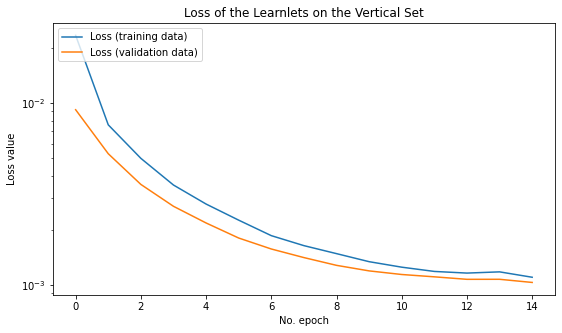

In [7]:
history = model.fit((im_train, sigma_train), target_train, steps_per_epoch=200, epochs=n_epochs, validation_data=((im_val, sigma_val), target_val), batch_size=batch_size)

plt.plot(history.history['loss'], label='Loss (training data)')
plt.plot(history.history['val_loss'], label='Loss (validation data)')
plt.title('Loss of the Learnlets on the Vertical Set')
plt.ylabel('Loss value')
plt.yscale('log')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

Model: "learnlet"
________________________________________________________________________________________________________________________
Layer (type)                                          Output Shape                                    Param #           
learnlet_analysis (LearnletAnalysis)                  multiple                                        2025              
________________________________________________________________________________________________________________________
scales_threshold (ScalesThreshold)                    multiple                                        90                
________________________________________________________________________________________________________________________
learnlet_synthesis (LearnletSynthesis)                multiple                                        2125              
Total params: 4,240
Trainable params: 4,130
Non-trainable params: 110
_________________________________________________________________

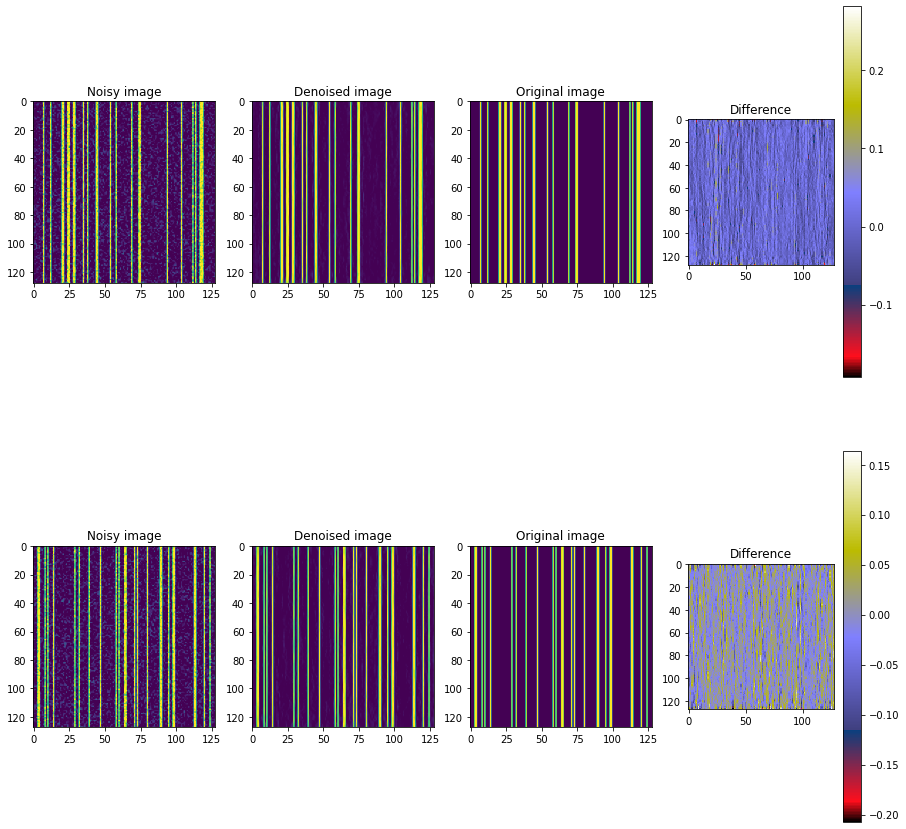

In [8]:
print(model.summary(line_length=120))

one_vertical_noiseless = tf.reshape(model.predict((im_val, sigma_val))[179,:,:], [im_size, im_size])
one_vertical_truth = tf.reshape(tf.convert_to_tensor(target_val[179,:,:]), [im_size, im_size])
one_vertical_noiseless = tf.cast(one_vertical_noiseless, one_vertical_truth.dtype)
one_vertical_noise = tf.reshape(tf.convert_to_tensor(im_val[179,:,:]), [im_size, im_size])
second_vertical_noiseless = tf.reshape(model.predict((im_val, sigma_val))[181,:,:], [im_size, im_size])
second_vertical_truth = tf.reshape(tf.convert_to_tensor(target_val[181,:,:]), [im_size, im_size])
second_vertical_noiseless = tf.cast(second_vertical_noiseless, second_vertical_truth.dtype)
second_vertical_noise = tf.reshape(tf.convert_to_tensor(im_val[181,:,:]), [im_size, im_size])


fig = plt.figure(num=0, figsize=(15,15))
plt.subplot(241)
plt.title('Noisy image')
plt.imshow(one_vertical_noise, vmin=0, vmax=1);
plt.subplot(242)
plt.imshow(one_vertical_noiseless, vmin=0, vmax=1);
plt.title('Denoised image')
plt.subplot(243)
plt.title('Original image')
plt.imshow(one_vertical_truth, vmin=0, vmax=1);
plt.subplot(244)
plt.title('Difference')
plt.imshow(one_vertical_noiseless-one_vertical_truth, interpolation='None',cmap='gist_stern');plt.colorbar()
plt.subplot(245)
plt.title('Noisy image')
plt.imshow(second_vertical_noise, vmin=0, vmax=1);
plt.subplot(246)
plt.imshow(second_vertical_noiseless, vmin=0, vmax=1);
plt.title('Denoised image')
plt.subplot(247)
plt.title('Original image')
plt.imshow(second_vertical_truth, vmin=0, vmax=1);
plt.subplot(248)
plt.title('Difference')
plt.imshow(second_vertical_noiseless-second_vertical_truth, interpolation='None',cmap='gist_stern');plt.colorbar()
plt.show()

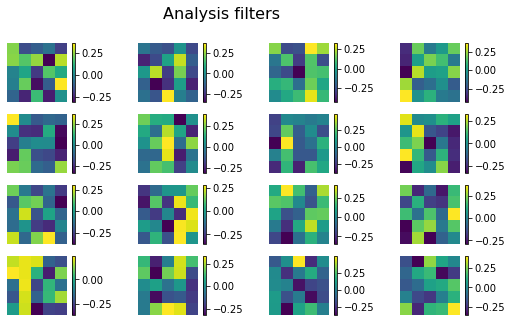

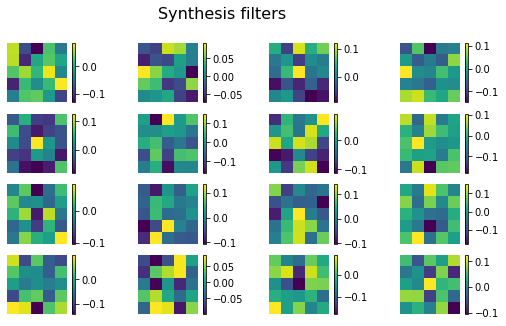

In [9]:
analysis_kernels = np.zeros((5,5,5,1,16))
synthesis_kernels = np.zeros((5,5,5,17,1))
for i in range(5):
  analysis_kernels[i] = np.copy(model.layers[0].get_weights()[i])
for i in range(5):
  synthesis_kernels[i] = np.copy(model.layers[2].get_weights()[i])
base_f = 4

save_analysis_kernels = model.layers[0].get_weights()[:]

fig, axs = plt.subplots(base_f, base_f, sharex=True, sharey=True)
for i in range(base_f):
  for j in range(base_f):
    im = axs[i, j].imshow(np.squeeze(analysis_kernels[0,:,:, 0, i * base_f + j]))
    axs[i, j].axis('off')
    fig.colorbar(im, ax=axs[i, j])
fig.suptitle('Analysis filters', fontsize=16)

fig, axs = plt.subplots(base_f, base_f, sharex=True, sharey=True)
for i in range(base_f):
  for j in range(base_f):
    im = axs[i, j].imshow(np.squeeze(synthesis_kernels[0,:,:, i * base_f + j, 0]))
    axs[i, j].axis('off')
    fig.colorbar(im, ax=axs[i, j])
fig.suptitle('Synthesis filters', fontsize=16)
plt.show()